### Compute results

In [1]:
import pandas as pd
import numpy as np
import nibabel as nib

from nilearn import datasets, image
from neurolang.frontend import NeurolangPDL

import neurolang
neurolang.config.disable_expression_type_printing()

/home/parietal/gzanitti/.local/miniconda3/envs/neurolang/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
JULICH_REGIONS_PATH = 'JULICH_BRAIN_CYTOARCHITECTONIC_MAPS_2_9_MNI152_2009C_NONL_ASYM.txt'
JULICH_ATLAS_PATH = 'JULICH_BRAIN_CYTOARCHITECTONIC_MAPS_2_9_MNI152_2009C_NONL_ASYM.pmaps.nii.gz'
PEAKS_PATH = 'peaks_IBC.csv'

RESAMPLE = 4

In [ ]:
nl = NeurolangPDL()

In [5]:
lines = []
with open(JULICH_REGIONS_PATH) as f:
    lines = f.readlines()

count = 0
res = []
for line in lines:
    if count == 0:
        count += 1
        continue
    splited = line.split(' ')
    res.append((splited[0], ' '.join(splited[1:-1])[1:], splited[-1][:-2]))

regions = pd.DataFrame(res, columns=['r_number', 'r_name', 'hemis'])
regions = regions[~regions.r_name.str.contains('GapMap')]
regions = regions.astype({'r_number': 'int64'})

In [6]:
## Atlas
mni_t1 = nib.load(datasets.fetch_icbm152_2009()['t1'])
mni_t1_4mm = image.resample_img(mni_t1, np.eye(3) * RESAMPLE)

pmaps_4d = image.resample_img(
    image.load_img(JULICH_ATLAS_PATH), mni_t1_4mm.affine, interpolation='nearest'
)

brain_regions_prob = []
prob_region_data = pmaps_4d.dataobj
non_zero = np.nonzero(pmaps_4d.dataobj)
for x, y, z, r in zip(*non_zero):
    p = prob_region_data[x][y][z][r]
    d = (p, x, y, z, r)
    brain_regions_prob.append(d)


: 

: 

In [5]:
cogAt = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('CogAt'),
    [
     	(
            'cogat.xml',
            'http://data.bioontology.org/ontologies/COGAT/download?'
            'apikey=8b5b7825-538d-40e0-9e9e-5ab9274a9aeb&download_format=rdf',
            {'move': 'cogat.xml'}
        )
    ]
)[0]

nl.load_ontology(cogAt)

4ee575e8-029a-11ed-9294-b02628b3d93a

In [3]:
df = pd.read_csv(PEAKS_PATH)
#df.head()

In [4]:
import math

def normalize_column(column_name):
    stim_mod_norm = set()
    for term in df[column_name].unique():
        if not isinstance(term, str) and math.isnan(term):
            stim_mod_norm.add('NaN')
            continue
        splitted = term.split(',')
        for s in splitted:
            stim_mod_norm.add(s.strip())
            
    new_column_name = ''.join(column_name.split(' '))
    stim_mod_norm = pd.DataFrame(stim_mod_norm).reset_index().rename(columns={'index': 'value', 0: new_column_name})
    
    norm_stim_mod = set()
    temp_df = df[['subject_id','img_id', column_name]].drop_duplicates()
    for index, row in temp_df.iterrows():
        if not isinstance(row[column_name], str) and math.isnan(row[column_name]):
            temp = ['NaN']
        else:
            temp = row[column_name].split(',')
        for t in temp:
            v = stim_mod_norm[stim_mod_norm[new_column_name] == t.strip()].value.values[0]
            norm_stim_mod.add((row.subject_id, row.img_id, v))
            
    return stim_mod_norm.set_index('value').join(
        pd.DataFrame(norm_stim_mod, columns=['subject_id','img_id', new_column_name]).set_index(new_column_name)
    ).reset_index(drop=True)


norm_tags = normalize_column('tag')
norm_tags['tag'] = norm_tags['tag'].apply(lambda x: x.strip().replace('_', ' ').replace('-', ' '))
taskParadigm = normalize_column('task_paradigm')


In [5]:
norm_tags.loc[norm_tags.tag.str.contains('visual pseudo word recognition'), 'tag'] = 'visual pseudoword recognition'

In [9]:
@nl.add_symbol
def word_lower(name: str) -> str:
    return name.lower()

subclass_of = nl.new_symbol(name='neurolang:subClassOf')
label = nl.new_symbol(name='neurolang:label')
hasTopConcept = nl.new_symbol(name='neurolang:hasTopConcept')

In [10]:
#taskParadigm.head()

In [11]:
#norm_tags.head()

In [13]:
#mni_t1 = nib.load(datasets.fetch_icbm152_2009()['t1'])
#mni_t1_4mm = image.resample_img(mni_t1, np.eye(3) * RESAMPLE)

df = df[['subject_id', 'img_id', 'X', 'Y', 'Z', 'Peak Stat', 'Cluster Size (mm3)']]

ijk_positions = (
    nib.affines.apply_affine(
        np.linalg.inv(mni_t1_4mm.affine),
        df[['X', 'Y', 'Z']]
    ).astype(int)
)
df['i'] = ijk_positions[:, 0]
df['j'] = ijk_positions[:, 1]
df['k'] = ijk_positions[:, 2]

df = df[['subject_id', 'img_id', 'i', 'j', 'k', 'Peak Stat', 'Cluster Size (mm3)']]
#df.head()

In [14]:
subject_id = df.subject_id.unique()
img_id = df.img_id.unique()

In [15]:
j_brain = nl.add_tuple_set(
    #(prob, x, y, z, region)
    brain_regions_prob,
    name='julich_brain'
)

j_regions = nl.add_tuple_set(
    #(r_number, r_name, hemis)
    regions.values,
    name='julich_regions'
)

taskP = nl.add_tuple_set(
    #(task, subject, img)
    taskParadigm,
    name='taskParadigmIBC'
)

tagsN = nl.add_tuple_set(
    #(tag, subject, img)
    norm_tags,
    name='tagsIBC'
)

dataIBC = nl.add_tuple_set(
    #(subject, img, i, j, k, peak stat, cluster size)
    df,
    name='dataIBC'
)

NameError: name 'brain_regions_prob' is not defined

In [16]:
ns_docs = df[['subject_id', 'img_id']]
ns_terms = norm_tags[['subject_id', 'img_id', 'tag']]

subjects = nl.add_uniform_probabilistic_choice_over_set(
        pd.DataFrame(df.subject_id.unique(), columns=['subjects']), name='subjects'
)

images = nl.add_uniform_probabilistic_choice_over_set(
        pd.DataFrame(df.img_id.unique(), columns=['subjects']), name='images'
)

In [17]:
frac_sample = 0.7
n_folds = 1#50


#df['subject_img'] = df.subject_id + '_' + df.img_id.astype(str)
#dataIBCdocs = df[['subject_img', 'i', 'j', 'k']]

#dataIBC = nl.add_tuple_set(
    #(subject_img, i, j, k)
#    dataIBCdocs,
#    name='dataIBCdocs'
#)

#ns_docs = pd.DataFrame(df.subject_img.unique(), columns=['doc'])

#norm_tags['subject_img'] = norm_tags.subject_id + '_' + norm_tags.img_id.astype(str)
#ns_terms = norm_tags[['subject_img', 'tag']]

ns_doc_folds = pd.concat(
    ns_docs.sample(frac=frac_sample, random_state=i).assign(fold=[i] * (int((len(ns_docs)* frac_sample))))
    for i in range(n_folds)
)
doc_folds = nl.add_tuple_set(ns_doc_folds, name='doc_folds')

terms = nl.add_tuple_set(ns_terms.values, name='terms')
docs = nl.add_uniform_probabilistic_choice_over_set(
        ns_docs.values, name='docs'
)

In [ ]:
for id_region in regions.r_number.values:

    with nl.scope as e:

        e.ontology_terms[e.onto_name] = (
            hasTopConcept[e.uri, e.cp] &
            label[e.uri, e.onto_name]
        )

        e.lower_terms[e.term] = (
            e.ontology_terms[e.onto_term] &
            (e.term == word_lower[e.onto_term])
        )

        e.filtered_terms[e.subject, e.image, e.term] = (
            e.lower_terms[e.term] &
            e.terms[e.subject, e.image, e.term]
        )

        (e.jbd @ e.p)[e.i, e.j, e.k, e.subject, e.image] = (
            e.dataIBC[e.subject, e.image, e.i, e.j, e.k, ..., ...] & # (subject, img, i, j, k, peak stat, cluster size)
            e.julich_brain[e.p, e.i, e.j, e.k, e.region] &
            (e.region == id_region)
        )

        e.img_studies[e.subject, e.image] = e.jbd[..., ..., ..., e.subject, e.image]
        e.img_left_studies[e.subject, e.image] = e.docs[e.subject, e.image] & ~(e.img_studies[e.subject, e.image])


        e.term_prob[e.t, e.fold, e.PROB[e.t, e.fold]] = (
            (
                e.filtered_terms[e.subject, e.image, e.t]
            ) // (
                e.img_studies[e.subject, e.image] &
                e.doc_folds[e.subject, e.image, e.fold] &
                e.docs[e.subject, e.image] &
                e.subjects[e.subject] &
                e.images[e.image]
            )
        )

        e.no_term_prob[e.t, e.fold, e.PROB[e.t, e.fold]] = (
            (
                e.filtered_terms[e.subject, e.image, e.t]
            ) // (
                e.img_left_studies[e.subject, e.image] &
                e.doc_folds[e.subject, e.image, e.fold] &
                e.docs[e.subject, e.image] &
                e.subjects[e.subject] &
                e.images[e.image]
            )
        )

        e.ans[e.term, e.fold, e.bf] = (
            e.term_prob[e.term, e.fold, e.p] &
            e.no_term_prob[e.term, e.fold, e.pn] &
            (e.bf == (e.p / e.pn))
        )

        res = nl.query((e.term, e.fold, e.bf), e.ans[e.term, e.fold, e.bf])
        mean_bf = res.as_pandas_dataframe().groupby('term').mean().drop(['fold'], axis=1).sort_values('bf', ascending=False)
        mean_bf.to_hdf('ibc_results.hdf', key=str(f'region_{id_region}'))

### Combine results

In [24]:
with nl.scope as e:

    e.ontology_terms[e.cp, e.onto_name] = (
        hasTopConcept[e.uri, e.cp] &
        label[e.uri, e.onto_name]
    )

    e.lower_terms[e.cp, e.term] = (
        e.ontology_terms[e.cp, e.onto_term] &
        (e.term == word_lower[e.onto_term])
    )

    e.filtered_terms[e.cp, e.term] = (
        e.lower_terms[e.cp, e.term] &
        e.terms[..., ..., e.term]
    )

    f_term = nl.query((e.cp, e.t), e.filtered_terms[e.cp, e.t])

In [30]:
df_cp = f_term.as_pandas_dataframe()[['cp', 't']]
df_cp = df_cp.drop_duplicates()



FileNotFoundError: File ./results/resample4/ibc_results_region_13.hdf does not exist

In [31]:
df_res

,term,bf,region,hemis,fold
0,action perception,0.841348,Ch 123 (Basal Forebrain),left,0.0
1,animacy decision,1.400524,Ch 123 (Basal Forebrain),left,0.0
2,animacy perception,1.400524,Ch 123 (Basal Forebrain),left,0.0
3,audiovisual perception,0.841348,Ch 123 (Basal Forebrain),left,0.0
4,auditory arithmetic processing,1.163033,Ch 123 (Basal Forebrain),left,0.0
...,...,...,...,...,...
11095,visual tool recognition,0.268502,SF (Amygdala),right,149.0
11096,visual word recognition,1.571226,SF (Amygdala),right,149.0
11097,visual working memory,0.580805,SF (Amygdala),right,149.0
11098,word maintenance,1.811219,SF (Amygdala),right,149.0


### Plot results

In [23]:
import pandas as pd
id_region = 10

res = pd.read_hdf(f'./results/resample4/ibc_results_region_{id_region}.hdf', key='results')
mean_bf = res.groupby('term').mean().drop(['fold'], axis=1).sort_values('bf', ascending=False)

In [19]:
mean_bf['region'] = id_region

NameError: name 'mean_bf' is not defined

In [20]:
lines = []
with open(JULICH_REGIONS_PATH) as f:
    lines = f.readlines()

count = 0
res = []
for line in lines:
    if count == 0:
        count += 1
        continue
    splited = line.split(' ')
    res.append((splited[0], ' '.join(splited[1:-1])[1:], splited[-1][:-2]))

regions = pd.DataFrame(res, columns=['r_number', 'r_name', 'hemis'])
regions = regions[~regions.r_name.str.contains('GapMap')]
regions = regions.astype({'r_number': 'int64'})

In [33]:
df_res = pd.DataFrame([], columns=['term', 'bf', 'region', 'hemis'])
for k, r in regions.iterrows():
    try:
        res = pd.read_hdf(f'./results/resample4/ibc_results_region_{r.r_number}.hdf', key='results')
        mean_bf = res.groupby('term').mean().drop(['fold'], axis=1).sort_values('bf', ascending=False)
        mean_bf['region'] = r.r_number
        mean_bf['hemis'] = r.hemis
        
        df_res = df_res.append(mean_bf)
    except Exception as e:
        print(e)
        continue

df_res2 = df_res.set_index('term').join(df_cp.set_index('t'))
df_res2 = df_res2.rename(columns={'cp': 'topConcept'})

File ./results/resample4/ibc_results_region_13.hdf does not exist
File ./results/resample4/ibc_results_region_24.hdf does not exist
File ./results/resample4/ibc_results_region_35.hdf does not exist
File ./results/resample4/ibc_results_region_46.hdf does not exist
File ./results/resample4/ibc_results_region_57.hdf does not exist
File ./results/resample4/ibc_results_region_68.hdf does not exist
File ./results/resample4/ibc_results_region_79.hdf does not exist
File ./results/resample4/ibc_results_region_90.hdf does not exist
File ./results/resample4/ibc_results_region_101.hdf does not exist
File ./results/resample4/ibc_results_region_112.hdf does not exist
File ./results/resample4/ibc_results_region_113.hdf does not exist
File ./results/resample4/ibc_results_region_114.hdf does not exist
File ./results/resample4/ibc_results_region_115.hdf does not exist
File ./results/resample4/ibc_results_region_116.hdf does not exist
File ./results/resample4/ibc_results_region_117.hdf does not exist
Fil

In [35]:
df_cp

,cp,t
0,Perception,visual color discrimination
96,Attention,visual working memory
173,Learning and Memory,visual place recognition
389,Learning and Memory,recognition
564,Social Function,social cognition
...,...,...
22766,,shape recognition
22842,,visual orientation
22886,Learning and Memory,reward processing
22964,Executive-Cognitive Control,updating


In [34]:
df_cp = f_term.as_pandas_dataframe()[['cp', 't']]
df_cp = df_cp.drop_duplicates()

In [ ]:
df_res = pd.DataFrame([], columns=['term', 'bf', 'region', 'hemis'])
for id_region, name, hemis in regions.values:
    df_region['region'] = name
    df_region['hemis'] = hemis
    
    df_res = df_res.append(df_region)


df_res2 = df_res.set_index('term').join(df_cp.set_index('t'))
df_res2 = df_res2.rename(columns={'cp': 'topConcept'})

In [40]:
df = pd.read_hdf('./combined_results_resample4.hdf', key='results')

In [48]:
len(df.region.unique())

55

In [47]:
df[df.topConcept == 'Language'].sort_values('bf', ascending=False).head(20)

,bf,region,hemis,topConcept
visual string recognition,8.156464,Area hOc5 (LOC),right,Language
visual string recognition,6.647521,"Area hOc1 (V1, 17, CalcS)",right,Language
visual string recognition,6.643720,Area 7A (SPL),left,Language
visual string recognition,5.748905,Area hOc4lp (LOC),left,Language
visual string recognition,4.777649,Area hIP3 (IPS),left,Language
visual string recognition,4.223489,Area hOc4lp (LOC),right,Language
visual string recognition,3.870865,Area 5Ci (SPL),right,Language
visual string recognition,3.732163,Area hIP8 (IPS),left,Language
visual string recognition,3.577858,Area hOc5 (LOC),left,Language
visual string recognition,3.564078,Area hOc3d (Cuneus),right,Language


In [49]:
dd = pd.read_hdf('./results/resample4/ibc_results_region_282.hdf')

FileNotFoundError: File ./results/resample4/ibc_results_region_282.hdf does not exist

In [50]:
df = pd.read_csv(PEAKS_PATH)

In [52]:
df[df['Cluster Size (mm3)'] > 1]

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),subject_id,img_id,task_paradigm,tag,row_id
0,1,-8.0,-80.0,44.0,5.476659,1136.0,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
4,2,30.0,-72.0,54.0,4.905578,416.0,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
5,3,-58.0,-54.0,2.0,4.682120,240.0,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
6,4,2.0,-8.0,58.0,4.585579,176.0,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
7,5,-40.0,-34.0,46.0,4.574038,176.0,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
...,...,...,...,...,...,...,...,...,...,...,...
1997047,129,-8.0,-76.0,-24.0,3.103166,8.0,sub-12,366886,synatcting and semantic fMRI task paradigm,"visual_string_recognition, string_maintenance,...",9512
1997048,130,-10.0,-52.0,74.0,3.103082,8.0,sub-12,366886,synatcting and semantic fMRI task paradigm,"visual_string_recognition, string_maintenance,...",9512
1997049,131,-34.0,54.0,8.0,3.090907,8.0,sub-12,366886,synatcting and semantic fMRI task paradigm,"visual_string_recognition, string_maintenance,...",9512
1997050,132,26.0,-60.0,52.0,3.090764,8.0,sub-12,366886,synatcting and semantic fMRI task paradigm,"visual_string_recognition, string_maintenance,...",9512


In [53]:
df

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),subject_id,img_id,task_paradigm,tag,row_id
0,1,-8.0,-80.0,44.0,5.476659,1136.0,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
1,1a,-16.0,-80.0,50.0,4.929037,NaN,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
2,1b,-14.0,-72.0,44.0,4.256287,NaN,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
3,1c,-14.0,-72.0,54.0,3.457384,NaN,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
4,2,30.0,-72.0,54.0,4.905578,416.0,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
...,...,...,...,...,...,...,...,...,...,...,...
1997047,129,-8.0,-76.0,-24.0,3.103166,8.0,sub-12,366886,synatcting and semantic fMRI task paradigm,"visual_string_recognition, string_maintenance,...",9512
1997048,130,-10.0,-52.0,74.0,3.103082,8.0,sub-12,366886,synatcting and semantic fMRI task paradigm,"visual_string_recognition, string_maintenance,...",9512
1997049,131,-34.0,54.0,8.0,3.090907,8.0,sub-12,366886,synatcting and semantic fMRI task paradigm,"visual_string_recognition, string_maintenance,...",9512
1997050,132,26.0,-60.0,52.0,3.090764,8.0,sub-12,366886,synatcting and semantic fMRI task paradigm,"visual_string_recognition, string_maintenance,...",9512


In [109]:
df = pd.read_hdf('./combined_results.hdf', key='results')
df.topConcept.unique()

array(['', 'Reasoning and Decision Making', 'Perception',
       'Learning and Memory', 'Emotion', 'Language', 'Action',
       'Social Function', 'Attention', 'Executive-Cognitive Control'],
      dtype=object)

In [79]:
df[(df.region.str.contains('HATA')) & (df.topConcept != '')].sort_values('bf', ascending=False).head(25)

,bf,region,hemis,topConcept
emotional face recognition,1.633064,HATA (Hippocampus),right,Perception
tool maintenance,1.504606,HATA (Hippocampus),right,Learning and Memory
syntactic parsing,1.341230,HATA (Hippocampus),right,Language
visual word recognition,1.237723,HATA (Hippocampus),right,Language
word maintenance,1.233254,HATA (Hippocampus),right,Learning and Memory
animacy decision,1.225570,HATA (Hippocampus),right,Reasoning and Decision Making
animacy perception,1.225570,HATA (Hippocampus),right,Perception
sentence processing,1.206656,HATA (Hippocampus),right,Language
working memory,1.104612,HATA (Hippocampus),right,Executive-Cognitive Control
response execution,1.077106,HATA (Hippocampus),right,Action


In [110]:
df[df.topConcept == 'Emotion'].sort_values('bf', ascending=False).head(25)

,bf,region,hemis,topConcept
empathy,1.626629,Area 25 (sACC),right,Emotion
empathy,1.536834,Area hOc3v (LingG),left,Emotion
empathy,1.351856,Area p32 (pACC),right,Emotion
empathy,1.316328,"Area hOc1 (V1, 17, CalcS)",left,Emotion
empathy,1.233181,HC-Parasubiculum (Hippocampus),left,Emotion
empathy,1.228328,"Area hOc2 (V2, 18)",left,Emotion
empathy,1.225743,Ventral Dentate Nucleus (Cerebellum),right,Emotion
empathy,1.218463,Area 25 (sACC),left,Emotion
empathy,1.190751,VTM (Amygdala),right,Emotion
empathy,1.174843,Area Id10 (Insula),left,Emotion


In [82]:
df = pd.read_csv(PEAKS_PATH)
df = df[df['Cluster Size (mm3)'] > 1]
df

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),subject_id,img_id,task_paradigm,tag,row_id
0,1,-8.0,-80.0,44.0,5.476659,1136.0,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
4,2,30.0,-72.0,54.0,4.905578,416.0,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
5,3,-58.0,-54.0,2.0,4.682120,240.0,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
6,4,2.0,-8.0,58.0,4.585579,176.0,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
7,5,-40.0,-34.0,46.0,4.574038,176.0,sub-12,363156,pleasantness rating task,"visual_face_recognition, face_perception, faci...",0
...,...,...,...,...,...,...,...,...,...,...,...
1997047,129,-8.0,-76.0,-24.0,3.103166,8.0,sub-12,366886,synatcting and semantic fMRI task paradigm,"visual_string_recognition, string_maintenance,...",9512
1997048,130,-10.0,-52.0,74.0,3.103082,8.0,sub-12,366886,synatcting and semantic fMRI task paradigm,"visual_string_recognition, string_maintenance,...",9512
1997049,131,-34.0,54.0,8.0,3.090907,8.0,sub-12,366886,synatcting and semantic fMRI task paradigm,"visual_string_recognition, string_maintenance,...",9512
1997050,132,26.0,-60.0,52.0,3.090764,8.0,sub-12,366886,synatcting and semantic fMRI task paradigm,"visual_string_recognition, string_maintenance,...",9512


In [97]:
df.sort_values(['Cluster Size (mm3)'], ascending=False).head(10000)

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),subject_id,img_id,task_paradigm,tag,row_id
1648112,1,68.0,-40.0,12.0,13.190289,196048.0,sub-06,368770,working memory fMRI task paradigm,"response_selection, response_execution, updating",7852
578770,1,-24.0,-64.0,66.0,16.190668,189440.0,sub-06,368800,Enumeration task,"enumeration, numerosity, shape_recognition, re...",2768
1597136,1,-38.0,-60.0,56.0,21.594391,169992.0,sub-01,368065,spatial localizer fMRI task paradigm,"visual_body_recognition, response_selection, h...",7610
383027,1,-56.0,-34.0,52.0,20.944561,168792.0,sub-13,369741,Enumeration task,"enumeration, numerosity, shape_recognition, re...",1860
528422,2,-64.0,-24.0,16.0,17.049499,155696.0,sub-13,363453,Enumeration task,"enumeration, numerosity, shape_recognition, re...",2541
...,...,...,...,...,...,...,...,...,...,...,...
1161772,3,0.0,-66.0,28.0,5.976930,4496.0,sub-09,369266,Pain-matrix narrative localizer,"imagined_emotional_pain, theory-of-mind",5542
63786,5,18.0,-62.0,68.0,9.302799,4496.0,sub-14,369794,spatial localizer fMRI task paradigm,visual_tracking,295
444579,1,64.0,-2.0,0.0,10.040868,4496.0,sub-07,365615,Social localizer fMRI task paradigm,voice_perception,2140
11840,4,-50.0,2.0,34.0,6.605882,4496.0,sub-01,360535,standard localizer fMRI task paradigm,"visual_arithmetic_processing, sentence_processing",62


In [88]:
df[df['Cluster Size (mm3)'] > 19500.0]

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),subject_id,img_id,task_paradigm,tag,row_id
3373,1,-18.0,-96.0,-20.0,14.845717,23928.0,sub-06,361825,Pain-matrix narrative localizer,"reading, response_execution, response_selectio...",18
3555,1,14.0,-96.0,20.0,10.922906,34616.0,sub-08,362260,gambling fMRI task paradigm,"response_selection, response_execution, punish...",19
4218,2,-24.0,-96.0,10.0,14.670571,19616.0,sub-07,368900,emotional localizer fMRI task paradigm,"emotion_expression_identification, gender_disc...",22
5665,2,16.0,-90.0,30.0,10.159112,19760.0,sub-12,369463,standard localizer fMRI task paradigm,vertical_checkerboard,29
10860,1,-38.0,-18.0,52.0,12.004861,28776.0,sub-05,368538,spatial localizer fMRI task paradigm,"visual_tool_recognition, response_selection, r...",56
...,...,...,...,...,...,...,...,...,...,...,...
1992386,2,4.0,-70.0,48.0,12.280997,23672.0,sub-15,363871,working memory fMRI task paradigm,"tool_maintenance, body_maintenance, place_main...",9496
1992668,3,16.0,-80.0,12.0,7.946811,20952.0,sub-05,365134,Mental time travel task,"auditory_perception, temporal_categorization, ...",9497
1993522,4,10.0,-78.0,4.0,7.151129,40904.0,sub-08,362351,Mental time travel task,"auditory_perception, memory_retrieval, spatial...",9500
1994538,1,16.0,-98.0,14.0,13.713439,22480.0,sub-13,369719,working memory fMRI task paradigm,"visual_place_recognition, place_maintenance, r...",9503


In [101]:
import math
196048.0 ** (1/3)

58.09259881450354

In [102]:
df = pd.read_csv(PEAKS_PATH)

<AxesSubplot:>

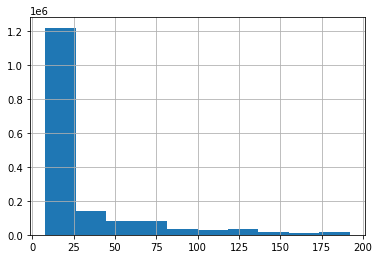

In [106]:
df[df['Cluster Size (mm3)'] < 200]['Cluster Size (mm3)'].hist()

In [107]:
200 ** (1/3)

5.848035476425731

In [2]:
# correr contra sujeto unico
# [x] threshold de 200 en xuster size
# CV balanceada con Topconcepts
# calcular dejando N sujetos afuera y usarlos para validar
# sacar sujeto y boostrapear entre task
# [ ] imagen coloreada por bf (maximum intensity projection)



# bertrand
# log(bf)
# cluster > 20
# julich ?
# compare neurosynth decoder
# multimodal vs monomodal

NameError: name 'bertrand' is not defined

In [8]:
df = df[df['Cluster Size (mm3)'] > 1]
df = df[df['Cluster Size (mm3)'] < 200]

In [10]:
df.subject_id.unique()

array(['sub-12', 'sub-04', 'sub-13', 'sub-06', 'sub-05', 'sub-15',
       'sub-01', 'sub-09', 'sub-07', 'sub-11', 'sub-02', 'sub-08',
       'sub-14'], dtype=object)

In [11]:
sub12 = df[df.subject_id == 'sub-12']
subs = df[df.subject_id != 'sub-12']

: 

: 

In [1]:
import os
directory = './results/thr_cluster/'
 
# iterate over files in
# that directory
df = pd.DataFrame([])
for filename in os.listdir(directory):
    temp = pd.read_hdf(directory + filename)
    df = pd.concat((df, temp))

df = df.sort_values(['region', 'fold'])

#f_term = pd.read_hdf('./term2cp.hdf')

#df = df.join(f_term.set_index('t'), on='term')

NameError: name 'pd' is not defined

In [ ]:
df